In [44]:
# !pip install mat73

import os

import mat73
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import torch.utils.data as td
import torchvision.transforms as transforms
from PIL import Image

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [45]:
def draw_boxes(img, boxes, linewidth=1):
    img = img.numpy().transpose(1, 2, 0)

    fig, ax = plt.subplots(figsize=(12, 9))

    ax.imshow(img)

    colors = ["orange", "green", "pink"]

    for i, bbox in enumerate(boxes):
        bbox = bbox.detach().cpu()

        x0, y0, x1, y1 = bbox[0].item(), bbox[1].item(), bbox[2].item(), bbox[3].item()
        x, y, w, h = x0, y0, x1 - x0, y1 - y0

        rect = patches.Rectangle((x, y), w, h, linewidth=linewidth, edgecolor=colors[i % len(colors)], facecolor="none")
        ax.add_patch(rect)

    plt.show()

In [61]:
def parse_annotation(ann):
    one_box = not isinstance(ann["label"], list)

    if one_box:
        x, y, w, h = ann["left"].item(), ann["top"].item(), ann["width"].item(), ann["height"].item()
        bboxes = [x, y, x + w, y + h]
        labels = [ann["label"].item()]
    else:
        bboxes = []
        labels = []

        for i in range(len(ann["label"])):
            x, y, w, h = ann["left"][i].item(), ann["top"][i].item(), ann["width"][i].item(), ann["height"][i].item()
            bboxes.append([x, y, x + w, y + h])
            labels.append(ann["label"][i].item())

    labels = torch.tensor(labels).long()
    bboxes = torch.tensor(bboxes).float()

    return bboxes, labels

In [62]:
IMAGE_SIZE = (256, 512)

IMAGE_TRANSFORM = transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(IMAGE_SIZE)
])


class DetectionDataset(td.Dataset):
    def __init__(self, folder, labels):
        self.folder = folder
        self.names = labels["name"]
        self.bboxes = labels["bbox"]

    def __getitem__(self, index):
        name = self.names[index]
        image = Image.open(f"{self.folder}/{name}")
        w, h = image.width, image.height
        image = IMAGE_TRANSFORM(image)

        bboxes, labels = parse_annotation(self.bboxes[index])

        nh, nw = IMAGE_SIZE
        scale_ = torch.tensor([nw / w, nh / h, nw / w, nh / h])
        bboxes = bboxes * scale_

        return image, bboxes, labels

    def __len__(self):
        return len(self.names)

In [63]:
class DataModule(pl.LightningDataModule):
    def __init__(
            self,
            dataset: DetectionDataset,
            batch_size: int = 32
    ):
        super().__init__()

        self.dataset = dataset
        self.batch_sz = batch_size

    @staticmethod
    def collate_fn(batch):
        images, bboxes, labels = [], [], []

        for image, bbox, label in batch:
            images.append(image)
            bboxes.append(bbox)
            labels.append(label)

        return torch.stack(images, dim=0), bboxes, labels

    def train_dataloader(self):
        return td.DataLoader(self.dataset, batch_size=self.batch_sz, shuffle=True, collate_fn=self.collate_fn)

In [92]:
class Detector(pl.LightningModule):
    def __init__(self, torch_model):
        super().__init__()
        self.model = torch_model

    def training_step(self, batch, _):
        images, bboxes, labels = batch

        targets = [
            {"boxes": boxes, "labels": label} for boxes, label in zip(bboxes, labels)
        ]

        out = self.model(images, targets)
        loss = 5 * out["loss_box_reg"] + 2.5 * out["loss_rpn_box_reg"] + 0.1 * out["loss_objectness"] + out[
            "loss_classifier"]

        return loss

    def configure_optimizers(self):
        return torch.optim.NAdam(self.model.parameters(), lr=1e-4)

### Initialize data module

In [93]:
%%time
train_labels = mat73.loadmat("../input/street-view-house-numbers/train_digitStruct.mat")

train = DetectionDataset(
    folder="../input/street-view-house-numbers/train/train",
    labels=train_labels["digitStruct"]
)

train_data_module = DataModule(train, batch_size=32)

CPU times: user 52 µs, sys: 2 µs, total: 54 µs
Wall time: 62 µs


### Define detection model and trainer. In my case it's *Faster-RCNN*

In [94]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

NUM_CLASSES = 11

fasterrcnn = fasterrcnn_resnet50_fpn(pretrained=True)

fasterrcnn.roi_heads.box_predictor = FastRCNNPredictor(
    fasterrcnn.roi_heads.box_predictor.cls_score.in_features,
    NUM_CLASSES
)

fasterrcnn.transform = GeneralizedRCNNTransform(
    min_size=min(IMAGE_SIZE),
    max_size=max(IMAGE_SIZE),
    image_mean=[0.485, 0.456, 0.406],
    image_std=[0.229, 0.224, 0.225]
)

Configure lightning _trainer_ and _detector_

In [95]:
detector = Detector(fasterrcnn)
trainer = pl.Trainer(accelerator="gpu", devices=1, max_epochs=1)

trainer.fit(detector, train_data_module)

Training: 0it [00:00, ?it/s]

In [96]:
torch.save(fasterrcnn, "fasterrcnn.pth")

In [103]:
from torchvision.ops import nms


def evaluate(path, model, filter_threshold=0.5, iou_threshold=0.5, device="cpu"):
    img = Image.open(path)
    w, h = img.width, img.height
    x = IMAGE_TRANSFORM(img).unsqueeze(0).to(device)

    model.eval().to(device)

    with torch.no_grad():
        output = model(x)[0]

    hi, wi = IMAGE_SIZE
    scale = torch.tensor([w / wi, h / hi, w / wi, h / hi])

    bboxes = output["boxes"].cpu() * scale
    scores = output["scores"].cpu()
    sliced = scores > filter_threshold
    indices = nms(bboxes[sliced], scores[sliced], iou_threshold=iou_threshold)

    draw_boxes(transforms.ToTensor()(img), bboxes[indices])

    return dict(bboxes=bboxes[indices], scores=scores[indices])

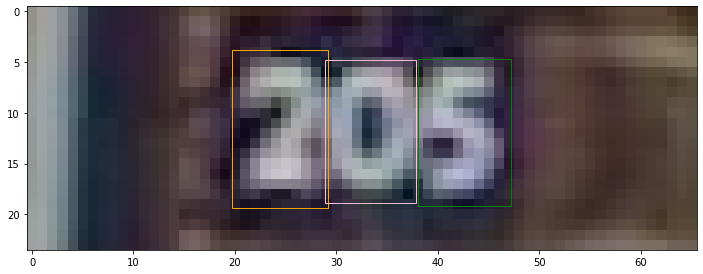

{'bboxes': tensor([[19.7326,  3.7733, 29.1934, 19.3896],
         [38.0371,  4.7012, 47.2237, 19.2056],
         [28.8806,  4.8031, 37.8466, 18.8457],
         [29.5291,  3.4606, 38.4221, 18.5813],
         [20.4155,  4.7405, 29.4878, 18.4652],
         [29.8247,  4.6674, 37.7063, 19.4005],
         [37.7934,  3.9098, 47.7024, 20.3458],
         [29.5234,  4.7776, 38.2033, 18.6219],
         [19.8731,  4.5639, 29.3203, 18.3601],
         [23.3060,  4.6965, 33.1244, 19.5553]]),
 'scores': tensor([0.9537, 0.9359, 0.9083, 0.1769, 0.1114, 0.1085, 0.0939, 0.0679, 0.0663,
         0.0511])}

In [109]:
test_folder = "../input/street-view-house-numbers/test/test"
test_images = os.listdir(test_folder)

index = 3
path = f"{test_folder}/{test_images[index]}"

evaluate(path, fasterrcnn, filter_threshold=0.5, iou_threshold=0.9, device="cuda")

In [110]:
from typing import List

from tqdm import tqdm
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision


def mAP(loader, model, thresholds: List[float], device="cpu"):
    metric = MeanAveragePrecision(iou_thresholds=thresholds)

    model.eval().to(device)

    for images, bboxes, labels in tqdm(loader):
        targets = [
            {"boxes": boxes.to(device), "labels": label.to(device)} for boxes, label in zip(bboxes, labels)
        ]

        with torch.no_grad():
            outputs = model(images.to(device))

        metric.update(outputs, targets)

    return metric.compute()

In [111]:
%%time
test_labels = mat73.loadmat("../input/street-view-house-numbers/test_digitStruct.mat")

test = DetectionDataset(
    folder="../input/street-view-house-numbers/test/test",
    labels=test_labels["digitStruct"]
)

CPU times: user 1min 53s, sys: 1.49 s, total: 1min 54s
Wall time: 1min 55s


In [22]:
test_loader = td.DataLoader(test, batch_size=64, collate_fn=train_data_module.collate_fn)

mean_ap = mAP(test_loader, fasterrcnn.eval(), device="cuda", thresholds=[0.5, 0.75, 0.9])
mean_ap

{'map': tensor(0.3479),
 'map_50': tensor(0.8082),
 'map_75': tensor(0.2326),
 'map_small': tensor(0.1181),
 'map_medium': tensor(0.2930),
 'map_large': tensor(0.3832),
 'mar_1': tensor(0.4277),
 'mar_10': tensor(0.4663),
 'mar_100': tensor(0.4664),
 'mar_small': tensor(0.2047),
 'mar_medium': tensor(0.4595),
 'mar_large': tensor(0.5147),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.)}

In [ ]:
from shapely.geometry import box
import numpy as np


def iou_precision_recall(t: box, p: box):
    t = box(*t)
    p = box(*p)

    inner = p.intersection(t).area
    iou = inner / p.union(t).area
    precision = inner / p.area
    recall = inner / t.area

    return iou, precision, recall


def precision_recall(loader, model, device="cuda"):
    model.eval()

    ious = []
    precisions = []
    recalls = []

    for images, bboxes, _ in tqdm(loader):
        with torch.no_grad():
            outputs = model(images.to(device))

        for predicted, target in zip(outputs, bboxes):
            target_metrics = []
            for t in target:
                iou, precision, recall = 0, 0, 0
                for p in predicted["boxes"]:
                    p = p.cpu()
                    _iou, _precision, _recall = iou_precision_recall(t, p)
                    if _iou > iou:
                        iou = _iou
                        precision = _precision
                        recall = _recall

                target_metrics.append([iou, precision, recall])

            ious.append(np.array(target_metrics)[:, 0].mean())
            precisions.append(np.array(target_metrics)[:, 1].mean())
            recalls.append(np.array(target_metrics)[:, 2].mean())

    iou = np.array(ious).mean()
    precision = np.array(precisions).mean()
    recall = np.array(recalls).mean()

    return iou, precision, recall

In [ ]:
iou, precision, recall = precision_recall(test_loader, fasterrcnn, device="cuda")

In [23]:
print(f"IoU: {iou:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

IoU: 0.7361
Precision: 0.8334
Recall: 0.8763
